# COMP24111 - Exercise 3: _Face recognition_

## 1. Task description

You will work on a face recognition task. The provided dataset includes face images of 40 subjects. There are a total of 400 images, with 10 images per subject. Each image contains 32×32=1024 pixels, with 256 grey levels per pixel.

## 2. Preparation

### Setting up

The functions that you need are defined in the source file we have provided you with. To use them you must import it first:

In [2]:
from lab3lib import load_data, show_single_face, show_faces, partition_data, split_left_right, join_left_right, show_split_faces

Now you can load the data:

In [3]:
data, labels = load_data()

### Visualising the dataset

You can observe the faces stored in a data matrix by using the functions `show_single_face()` and `show_faces()`.

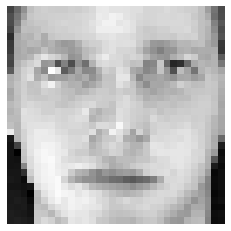

In [4]:
# Display a single example.
show_single_face(data[0, :])

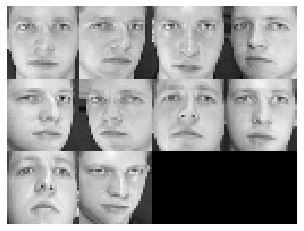

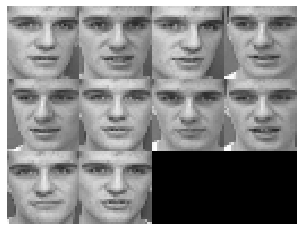

In [9]:
# Display the first 16 examples in a 4x4 grid.
show_faces(data[0:10, :], num_per_row=4)
show_faces(data[290:300, :], num_per_row=4)

### Splitting into train and test set

A data partition function is supplied to facilitate your experiments. It randomly splits the provided data into the training and test sets, where the training set contains $N$ samples per class and the test set contains
the remaining samples. It takes the labels and the specified number $N$ as the input. It returns the sample indices in the training and test set. For example, the following code divides a given set of 400 samples into a training set containing 3 samples per subject and a test set containing 7 samples per subject:

In [17]:
import numpy as np

tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]


## 3. $L_2$-regularised least squares implementation

Now, you will need to implement the function `l2_rls_train` below. It should train a linear model by minimising the $L_2$-regularised sum of squares loss using the normal equations (this is called $L_2$*-regularised least squares model*, or *ridge regression model*). It should support both single-output and multi-output cases. This function should take a set of training samples and a user-specified regularisation parameter $\lambda$ as the input, and return the predicted weights.

In [18]:
import numpy as np
from numpy.linalg import inv

def l2_rls_train(tr_data, tr_labels, regularisation):
    
    # This is just to be consistent with the lecture notes.
    X, y = tr_data, tr_labels
    n = len(tr_data)
    I = np.identity(1025)
    
    # Expand X with a column of ones.
    column_of_ones = np.ones((n, 1), dtype=int)
    x_tilde = np.append(column_of_ones, X, axis=1)
    x_tilde_t = x_tilde.transpose()
    
    # Compute the coefficient vector.
    if regularisation == 0:
        w = np.linalg.pinv(x_tilde)@ y
    
    else:
        w = (inv((x_tilde_t@x_tilde)+regularisation*I))@(x_tilde_t@y)
    
    # Return model parameters.
    return w

Once you have trained your model, you can use it on to predict new data. Implement the following function to do this.

In [19]:
def l2_rls_predict(w, data):

    # This is just to be consistent with the lecture notes.
    X = data
    n = len(data)
    
    # Your code goes here
    column_of_ones = np.ones((n, 1))
    x_tilde = np.append(column_of_ones, X, axis=1)
    predicted_y = x_tilde @ w
    
    return predicted_y

## 4. Experiments

Start to use your functions `l2_rls_train` and `l2_rls_predict` to perform the following experiments.

### Experiment 1: Binary Classification

Start with a binary classification task to classify face images for subjects “1” and “30”.

Train three classifiers:
1. Set $y=-1$ for samples from “1” and $y=+1$ for samples from “30” to train a linear model, and use the threshold $T= 0$ to obtain the class prediction.
2. Set $y=0$ for samples from “1” and $y=1$ for samples from “30” to train a linear model, and use the threshold $T= 0.5$ to obtain the class prediction.
2. Set $y=1$ for samples from “1” and $y=30$ for samples from “30” to train a linear model, and use the threshold $T= 15.5$ to obtain the class prediction.

Randomly select 3 images per subject for training, and use the remaining images for testing. Train your classifier 1 and test it with a fixed regularisation parameter $\lambda$=0. Repeat this process 50 times and record the training and test errors.

In [20]:
def trainingTestingErr(predictions, T, label_class_1, label_class_30, label):
    # classify depending on output and threshold
    for i in range(0, predictions.size):
        if (predictions[i] < T):
            predictions[i] = label_class_1
        elif (predictions[i] >= T):
            predictions[i] = label_class_30
            
    # Calculate how many were wrongly predicted by comparing each element
    # When compared if the two elements don't equal each other than it has been wrongly predicted
    # Start with training error at 0
    err = 0
    for i in range (0, predictions.size):
        if (predictions[i] != label[i]):
            err += 1 
    
    # Calculate error rate
    err = err / predictions.size
    return err
    

def exp1(label_class_1, label_class_30):

    # Mapping the labels and partition the data
    # partitions the 400 samples into 120 training and 280 testing
    all_tr_ind, all_te_ind = partition_data(labels, num_per_class=3)
    
    # then gets training and testing indices for subject 1 and subject 30 
    # training has 3 samples per subject
    # testing has 7 samples per subject
    tr_ind = np.concatenate((all_tr_ind[:3], all_tr_ind[29*3:30*3]), axis=None)
    te_ind = np.concatenate((all_tr_ind[:7], all_te_ind[29*7:30*7]), axis=None)
    
    # np.full returns an array with specific dimensions and fill value
    # get the data for each subject associated with each index value
    tr_data = data[tr_ind, :]
    tr_label = np.concatenate((np.full(3, label_class_1), np.full(3, label_class_30)), axis=None)
    
    # Same for testing data, this time with 7 samples
    te_data = data[te_ind, :]
    te_label = np.concatenate((np.full(7, label_class_1), np.full(7, label_class_30)), axis=None)

    
    # Training the model with the training data and training labels
    w = l2_rls_train(tr_data, tr_label, 0)
    
    # Defining the threshold
    threshold = (label_class_1 + label_class_30) / 2
    
    # Perform prediction for training and compute the training error
    predictions_training = l2_rls_predict(w, tr_data)
    # Calls the function which finds the error rate
    tr_err = trainingTestingErr(predictions_training, threshold, label_class_1, label_class_30, tr_label)
    
    # Perform prediction for testing and compute the test error
    predictions_testing = l2_rls_predict(w, te_data)
    # Calls the function which finds the error rate
    te_err = trainingTestingErr(predictions_testing, threshold, label_class_1, label_class_30, te_label)
      
    # Return the training error and the testing error
    return tr_err, te_err

In [21]:
# Use the `exp1()` function to experiment with classifier 1.

# Create an empty array for storing testing error rates
test_err_classifier1 = np.empty(50)

# run the experiment 50 times and calculate and store the testing error for each run within an array
for i in range(50):
    tr_err, te_err = exp1(-1, 1)
    
    # print training and testing error rates
    print(i,"\n Training Error: ", (tr_err * 100),"%")
    print(" Testing Error: ", (te_err * 100),"%", "\n")
    # Store in array
    test_err_classifier1[i] = te_err

0 
 Training Error:  0.0 %
 Testing Error:  7.142857142857142 % 

1 
 Training Error:  0.0 %
 Testing Error:  7.142857142857142 % 

2 
 Training Error:  0.0 %
 Testing Error:  14.285714285714285 % 

3 
 Training Error:  0.0 %
 Testing Error:  0.0 % 

4 
 Training Error:  0.0 %
 Testing Error:  7.142857142857142 % 

5 
 Training Error:  0.0 %
 Testing Error:  7.142857142857142 % 

6 
 Training Error:  0.0 %
 Testing Error:  14.285714285714285 % 

7 
 Training Error:  0.0 %
 Testing Error:  7.142857142857142 % 

8 
 Training Error:  0.0 %
 Testing Error:  7.142857142857142 % 

9 
 Training Error:  0.0 %
 Testing Error:  7.142857142857142 % 

10 
 Training Error:  0.0 %
 Testing Error:  7.142857142857142 % 

11 
 Training Error:  0.0 %
 Testing Error:  7.142857142857142 % 

12 
 Training Error:  0.0 %
 Testing Error:  7.142857142857142 % 

13 
 Training Error:  0.0 %
 Testing Error:  21.428571428571427 % 

14 
 Training Error:  0.0 %
 Testing Error:  7.142857142857142 % 

15 
 Training Er

Repeat the same experiment for classifier 2.

In [22]:
# Use the `exp1()` function to experiment with classifier 2.
# Create an empty array for storing testing error rates
test_err_classifier2 = np.empty(50)

# run the experiment 50 times and calculate and store the testing error for each run within an array
for i in range(50):
    tr_err, te_err = exp1(0, 1)
    
    # print training and testing error rates
    print(i,"\n Training Error: ", (tr_err * 100),"%")
    print(" Testing Error: ", (te_err * 100),"%", "\n")
    # Store in array
    test_err_classifier2[i] = te_err


0 
 Training Error:  0.0 %
 Testing Error:  21.428571428571427 % 

1 
 Training Error:  0.0 %
 Testing Error:  7.142857142857142 % 

2 
 Training Error:  0.0 %
 Testing Error:  7.142857142857142 % 

3 
 Training Error:  0.0 %
 Testing Error:  0.0 % 

4 
 Training Error:  0.0 %
 Testing Error:  7.142857142857142 % 

5 
 Training Error:  0.0 %
 Testing Error:  7.142857142857142 % 

6 
 Training Error:  0.0 %
 Testing Error:  7.142857142857142 % 

7 
 Training Error:  0.0 %
 Testing Error:  0.0 % 

8 
 Training Error:  0.0 %
 Testing Error:  7.142857142857142 % 

9 
 Training Error:  0.0 %
 Testing Error:  14.285714285714285 % 

10 
 Training Error:  0.0 %
 Testing Error:  14.285714285714285 % 

11 
 Training Error:  0.0 %
 Testing Error:  7.142857142857142 % 

12 
 Training Error:  0.0 %
 Testing Error:  7.142857142857142 % 

13 
 Training Error:  0.0 %
 Testing Error:  7.142857142857142 % 

14 
 Training Error:  0.0 %
 Testing Error:  14.285714285714285 % 

15 
 Training Error:  0.0 %
 

Repeat the same experiment for classifier 3.

In [23]:
# Use the `exp1()` function to experiment with classifier 3.
# Create an empty array for storing testing error rates
test_err_classifier3 = np.empty(50)

# run the experiment 50 times and calculate and store the testing error for each run within an array
for i in range(50):
    tr_err, te_err = exp1(1, 30)
    
    # print training and testing error rates
    print(i,"\n Training Error: ", (tr_err * 100),"%")
    print(" Testing Error: ", (te_err * 100),"%", "\n")
    # Store in array
    test_err_classifier3[i] = te_err


0 
 Training Error:  0.0 %
 Testing Error:  7.142857142857142 % 

1 
 Training Error:  0.0 %
 Testing Error:  7.142857142857142 % 

2 
 Training Error:  0.0 %
 Testing Error:  7.142857142857142 % 

3 
 Training Error:  0.0 %
 Testing Error:  14.285714285714285 % 

4 
 Training Error:  0.0 %
 Testing Error:  7.142857142857142 % 

5 
 Training Error:  0.0 %
 Testing Error:  7.142857142857142 % 

6 
 Training Error:  0.0 %
 Testing Error:  0.0 % 

7 
 Training Error:  0.0 %
 Testing Error:  14.285714285714285 % 

8 
 Training Error:  0.0 %
 Testing Error:  7.142857142857142 % 

9 
 Training Error:  0.0 %
 Testing Error:  7.142857142857142 % 

10 
 Training Error:  0.0 %
 Testing Error:  7.142857142857142 % 

11 
 Training Error:  0.0 %
 Testing Error:  0.0 % 

12 
 Training Error:  0.0 %
 Testing Error:  7.142857142857142 % 

13 
 Training Error:  0.0 %
 Testing Error:  7.142857142857142 % 

14 
 Training Error:  0.0 %
 Testing Error:  0.0 % 

15 
 Training Error:  0.0 %
 Testing Error:  

Print the test error mean and standard deviation of the three classifiers and display them in the same plot.

CLASSIFIER 1: 
    Mean training error rate:  0.09142857142857143
    Standard deviation of the error rates 0.05897076411585798 

CLASSIFIER 2: 
    Mean training error rate:  0.08571428571428569
    Standard deviation of the error rates 0.05345224838248487 

CLASSIFIER 3: 
    Mean training error rate:  0.07285714285714286
    Standard deviation of the error rates 0.04400834800214103 



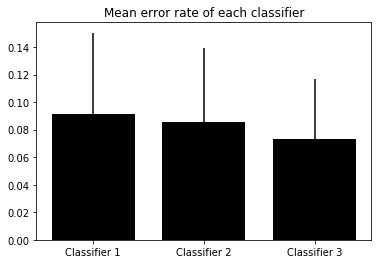

In [24]:
all_the_means = [np.mean(test_err_classifier1), np.mean(test_err_classifier2), np.mean(test_err_classifier3)]
all_deviations = [np.std(test_err_classifier1), np.std(test_err_classifier2), np.std(test_err_classifier3)]

# Print mean error rate and standard deviation for each classifier
print("CLASSIFIER 1: ")
print("    Mean training error rate: ", all_the_means[0])
print("    Standard deviation of the error rates", all_deviations[0], "\n")
print("CLASSIFIER 2: ")
print("    Mean training error rate: ", all_the_means[1])
print("    Standard deviation of the error rates", all_deviations[1], "\n")
print("CLASSIFIER 3: ")
print("    Mean training error rate: ", all_the_means[2])
print("    Standard deviation of the error rates", all_deviations[2], "\n")

# Plotting the error rates for each classifier
from matplotlib import pyplot as plt

x = ["Classifier 1", "Classifier 2", "Classifier 3"]
x_pos = [i for i, z in enumerate(x)]

plt.bar(x_pos, all_the_means, width=0.75, color="black", yerr=all_deviations)
plt.xticks(x_pos, x)
plt.title("Mean error rate of each classifier")
plt.show()

Compare the three classifiers and comment on your results.

What training accuracies do you obtain with your linear classifier? Explain the reason.

Between subjects “1” and “30”, which one is more difficult for the linear classifier to recognise? Explain it.

### Experiment 2: Multi-class Classification

Now, proceed to the multi-class classification task to classify face images for all the 40 subjects. Decide an appropriate way to set your target output and make class prediction. 

Split your data to two sets: the training set contains 5 randomly selected images per subject and the test set contains the remaining images. The training set is used to train the model and select hyper-parameter $\lambda$, while the test set is only for final assessment of the trained classifier with the selected $\lambda$. 

Design an appropriate and complete machine learning experiment, which should include the training, hyper-parameter selection and evaluation stages. You can choose from the random subsampling, $k$-fold CV and LOO approaches for hyper-parameter selection. 

Write your code below and make sure it compiles. Show your code to the TA, explain your classifier and experiment design.

In [186]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def fold(tr_ind, classValue, lambdaValue):

    # Initialise the indices arrays for training and testing
    tr_index = []
    te_index = []

    # for loop appends 1 every 5 into the testing and puts the rest in training indices array
    for i in range(0, 200):
        if ((i-classValue)%5 == 0):
            te_index.append(tr_ind[i])

        else:
            tr_index.append(tr_ind[i])

    training_data = data[tr_index]
    testing_data = data[te_index]

    training_labels = labels[tr_index]
    testing_labels = labels[te_index]


    # Made a row of ones
    y_matrix = np.ones((40))

    # Make a row of zeros
    # (Class - 1) is the column index, indicating that class
    # Add every row in turn to the y_matrix by using vstack
    # vstack concatenates arrays e.g. vstack(([1, 2]),([3, 4])
    # would become [[1,2],
    #               [3,4]]
    for i in range(160):
        y = np.zeros((40))
        y_class = (training_labels[i] - 1)
        y[y_class] = 1
        y_matrix = np.vstack((y_matrix, y))

    # Delete the the top row
    y_matrix = np.delete(y_matrix, (0), axis=0)

    # Train the data
    weight = l2_rls_train(training_data, y_matrix, lambdaValue)

    # Predict the data with the returned weight from class1 and the 40 test samples
    predicted_y_matrix = l2_rls_predict(weight, testing_data)

    # Now take the predicted_y matrix and turn it into an array showing which class its in
    # I use the argmax function to find the largest value within the array
    # I add 1 to the value to it links up with the other arrays
    predicted_y = []
    for i in range(40):
        this_row = predicted_y_matrix[i]
        nearest_class = (np.argmax(this_row)+1)
        predicted_y.append(nearest_class)

    te_err = ((len(testing_labels) - np.sum(testing_labels == predicted_y)) / len(testing_labels))
    return te_err


def hyperparameter_selection(tr_ind):
    """
    Finds the best value for lambda using k-fold technique.
    """

    # Get training labels for all 200 images
    tr_labels = labels[tr_ind]
    
    # Initialise empty array in order to store the different values and error values of every lambda I use
    lambda_value = []
    error_per_lambda = []
    
    # Due to the log relationship of Lambda I have to vary my lambda in the same way.
    # Used the logarithmic numpy function in order to vary my value of lambda
    numbers_sizes = np.logspace(-3, 10, 50)
    for lambdaValue in numbers_sizes:
        
        # I will use the 5 fold method, so I will take 1 image from each class for the testing data and have 
        # 4 from each for the training data
        error_per_fold = []
        
        # Created a fold function for each of the 5 folds
        # Then called the function 5 times passing in different values for each.
        te_err_1 = fold(tr_ind, 0, lambdaValue)
        te_err_2 = fold(tr_ind, 1, lambdaValue)
        te_err_3 = fold(tr_ind, 2, lambdaValue)
        te_err_4 = fold(tr_ind, 3, lambdaValue)
        te_err_5 = fold(tr_ind, 4, lambdaValue)
        
        # Appends the testing error from each fold to the error array
        error_per_fold.append(te_err_1)
        error_per_fold.append(te_err_2)
        error_per_fold.append(te_err_3)
        error_per_fold.append(te_err_4)
        error_per_fold.append(te_err_5)
        
        # Finds the mean error for all 5 folds
        error_fold_mean = np.mean(error_per_fold)
        # The mean error for all 5 folds is the error for that value of lambda
        error_per_lambda.append(error_fold_mean)
        # Keeps a records of each lambda value that is tested
        lambda_value.append(lambdaValue)
        
    # The best value of lambda is the one in which the error is the smallest
    # Used argmin to find the smallest error 
    bestValue = np.argmin(error_per_lambda)
    # best_lambda has the same index as the bestValue
    best_lambda = lambda_value[bestValue]
    return best_lambda

In [187]:
average_testing_err_array = []

# Finds the best lambda value to use which produces the least amount of errors
best_lambda = hyperparameter_selection(tr_ind)
print("Best Lambda: ", best_lambda, "\n")
    
# Run the experiment 10 times in order to get a good sense of how much the testing error varies 
for k in range (11):
    print("EXPERIMENT: ",  k)
    tr_ind, te_ind = partition_data(labels, 5)
    
    tr_labels = labels[tr_ind]
    tr_data = data[tr_ind]
    
    te_labels = labels[te_ind]
    te_data = data[te_ind]
    
    # Create a matrix of ones
    y_matrix = np.ones((40))
    
    # Make a row of zeros
    # (Class - 1) is the column index, indicating that class
    # Add every row in turn to the y_matrix by using vstack
    # vstack concatenates arrays e.g. vstack(([1, 2]),([3, 4])
    # would become [[1,2],
    #               [3,4]]
    for i in range(200):
        y = np.zeros((40))
        y_class = (tr_labels[i] - 1)
        y[y_class] = 1
        y_matrix = np.vstack((y_matrix, y))
    
    # Delete the top row as it is not necessary any more
    y_matrix = np.delete(y_matrix, (0), axis=0)
    
    # Train the model by using the training data and y_matrix
    weight = l2_rls_train(tr_data, y_matrix, best_lambda)
    
    # Predict based of the training 
    predicted_y_matrix = l2_rls_predict(weight, te_data)
    predicted_y = []
    
    # Now test with remaining 200 samples
    for i in range(200):
        this_row = predicted_y_matrix[i]
        nearest_class = (np.argmax(this_row)+1)
        predicted_y.append(nearest_class)
    
    te_err = ((len(te_labels) - np.sum(te_labels == predicted_y)) / len(te_labels))
        
    print("    Testing Error For Each Lambda: ", te_err)
    average_testing_err_array.append(te_err)

    
print("\nTesting Errors For All Experiments: ", average_testing_err_array)
print("Mean of All Testing Errors: ", np.mean(average_testing_err_array))
    

Best Lambda:  7906.043210907702 

EXPERIMENT:  0
    Testing Error For Each Lambda:  0.04
EXPERIMENT:  1
    Testing Error For Each Lambda:  0.07
EXPERIMENT:  2
    Testing Error For Each Lambda:  0.055
EXPERIMENT:  3
    Testing Error For Each Lambda:  0.07
EXPERIMENT:  4
    Testing Error For Each Lambda:  0.06
EXPERIMENT:  5
    Testing Error For Each Lambda:  0.085
EXPERIMENT:  6
    Testing Error For Each Lambda:  0.07
EXPERIMENT:  7
    Testing Error For Each Lambda:  0.085
EXPERIMENT:  8
    Testing Error For Each Lambda:  0.05
EXPERIMENT:  9
    Testing Error For Each Lambda:  0.04
EXPERIMENT:  10
    Testing Error For Each Lambda:  0.06

Testing Errors For All Experiments:  [0.04, 0.07, 0.055, 0.07, 0.06, 0.085, 0.07, 0.085, 0.05, 0.04, 0.06]
Mean of All Testing Errors:  0.06227272727272728


Analyse the classification results, and pick some subjects that are considered the most difficult to recognise by your classifier. Show and explain it to the TA.

### Experiment 3: Face Completion

Revise the “Regression Example II” on face completion in Chapter 2. The task is to guess the 512 pixels of the right face from the 512 pixels of the left face. 

The following command can be used to extract the left and right faces from the input data.

In [45]:
left, right = split_left_right(data)

And you can visualise them with the function `show_split_faces()`:

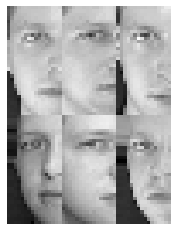

In [46]:
show_split_faces(left[:6, :], num_per_row=3)

Build a face completion model using your functions `l2_rls_train` and `l2_rls_predict`. Design an experiment to assess your model, which should include appropriate training and testing. Use mean absolute percentage error to evaluate the regression performance. You do not need to bother with hyper-parameter selection, but simply set $\lambda$=0.

Write your code below and make sure it compiles. Show your code to the TA, explain your model and experiment design, and demonstrate results.

In [132]:

tr_ind, te_ind = partition_data(labels, num_per_class=5)
tr_data = data[tr_ind]
te_data = data[te_ind]

# Split the testing and training data faces into left side and right side
leftTesting, rightTesting = split_left_right(te_data)
leftTraining, rightTraining = split_left_right(tr_data)

# Use the left and right training data to train the model
w = l2_rls_train(leftTraining, rightTraining, 0)
# Make the predictions with the w values and the leftTesting
# LeftTesting is used as we want to pass in only the left face
predictions = l2_rls_predict(w, leftTesting)

# Initialise values before for loops
mean_abs_percentage_array = []
each_term = 0

# Calculate the mean absolute percentage error by going through every item in the array
# Nested for loop used to go through 2D array
for i in range(200): #200 is the value for half the faces
    for j in range (512): # half an image contains this many pixels
        # Need to use absolute to get rid of any minus values 
        each_term += ((np.abs(rightTesting[i][j] - predictions[i][j])) / np.abs(rightTesting[i][j]))
    
    mean_abs_percentage = (one_term / (200 * 512))
    mean_abs_percentage_array.append(mean_abs_percentage)
    

print("Average Mean Absolute Percentage Error: ", np.mean(mean_abs_percentage_array))

Average Mean Absolute Percentage Error:  0.24492258035315737


Visualise and compare the ground truth face (include both the left and right parts) and the completed face (include both the true left and predicted right parts) for 3 randomly chosen testing samples below. You can use `join_left_right(left, right)` to concatenate the left and right halves of a set of faces.

[ 49 132  55]


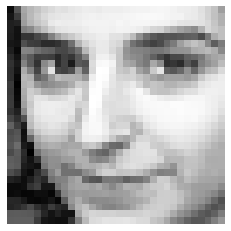

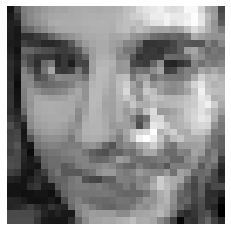

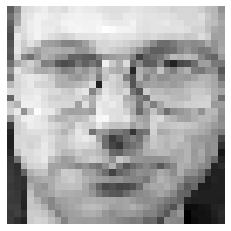

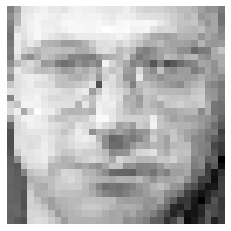

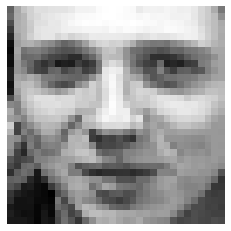

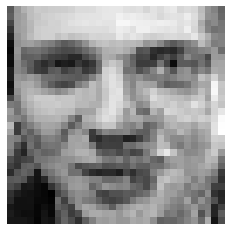

In [130]:
# Chooses 3 random faces from the sample
three_rand = np.random.randint(200, size=3)
print(three_rand)

# The new faces with the right side being the predicted face
newFaces = join_left_right(leftTesting, predictions, h=32, w=16)

# Face 1:
show_single_face(te_data[three_rand[0]])
show_single_face(newFaces[three_rand[0]])

# Face 2:
show_single_face(te_data[three_rand[1]])
show_single_face(newFaces[three_rand[1]])

# Face 3:
show_single_face(te_data[three_rand[2]])
show_single_face(newFaces[three_rand[2]])

Does your model work well? Comment on it.

## 5. Deliverables and Marking

By the deadline, you should submit one single Jupyter file using GitLab. Please find the coursework submission instruction from the following link: https://wiki.cs.manchester.ac.uk/index.php/UGHandbook19:Coursework .

This exercise is worth 15 marks – marks will be allocated roughly on the basis of: 
- rigorous experimentation,
- knowledge displayed when talking to the TA,
- problem solving skill,
- self-learning ability,
- how informative and well presented your graphs are,
- language and ease of reading.

You must be able to explain any code you've written in order to get full marks. During the marking session we will ask you to run all cells in your Jupyter file, so ensure that the file is runnable using the "Restart Kernel and Run All Cells" menu option.

The lab is marked out of 15:

|                          |         |
|:------------------------ |--------:|
| $L_2$-RLS Implementation | 3 marks |
| Experiment 1             | 4 marks |
| Experiment 2             | 4 marks |
| Experiment 3             | 4 marks |